In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
import scipy as scpy
from scipy import stats
from scipy import ndimage
from skimage.transform import resize
from cv2 import cv2

import dionysus as d

import os
import csv
import pandas as pd
import pickle

from sklearn.cluster import KMeans

from mpl_toolkits.mplot3d import Axes3D
from skimage import io

import importlib
import helper_functions
importlib.reload(helper_functions)
from helper_functions import *

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'arial'
# rcParams['font.sans-serif'] = ['Tahoma']
rcParams.update({'font.size': 16})

In [2]:
image_loc = '../../../SH-CH/3D-SIM paxillin/'
file_name = image_loc
path, dirs, files = os.walk(file_name).__next__()
len_files = len(files)-1

files = [file for file in files if '2um' in file and 'tif' in file]
actin_files = [file for file in files if 'C=1' in file]
other_files = [file for file in files if 'C=0' in file]
file_inds = [file.split(' ')[1].split('_')[0] for file in actin_files]

In [3]:
pix_sizes = dict.fromkeys(['017','015','013','011','008','004'] ,30.72/1024)
pix_sizes['005'] = 26.34/878
pix_sizes['003'] = 14.94/498

z_step = 100 #nm

In [8]:
other_species = 'Paxillin'
pod_analysis_distance = 2. #um

all_clusters = []
all_centers = []
for ind in file_inds: #['001','003']:
    try:
        actin_file = image_loc + [file for file in actin_files if ind in file][0]
        print(actin_file)
    #     other_file = image_loc + [file for file in other_files if ind in file][0]
    #     save_file = save_file_name+ind+'.tif'

        actin_stack = io.imread(actin_file)
    #     other_stack = io.imread(other_file)

        actin = np.mean(actin_stack,axis=0)
        plt.figure()
        plt.imshow(actin)
    #     other = np.mean(other_stack,axis=0)

        pix_size = pix_sizes[ind]
        len_micron = int(1/pix_size)
        pod_filt = int(0.3*len_micron)
        site_filt = int(1.5*len_micron)

        file_name = ''
        pods, sites = find_pod_and_sites_ph(actin,pod_filt,site_filt,plot_bool=False,plot_pers=False,save_file = file_name)
        clusters,centers,radii = cluster_refine_pods_and_sites(pods,sites,actin,pix_size,plot_bool=True,save_file = file_name,upper_lim=3,lower_lim=1)
        all_clusters.append(clusters)
        all_centers.append(centers)
        print(ind + ' is done')
    except:
        print(ind + ' has failed')
        continue


In [26]:
# pickle.dump({'all_clusters':all_clusters,'all_centers':all_centers},open('disc_3DSIM_paxillin_FoundLoc.pickled','wb'))


In [4]:
stored_results = pickle.load(open('disc_3DSIM_paxillin_FoundLoc.pickled','rb'))
all_clusters = stored_results["all_clusters"]
all_centers = stored_results["all_centers"]

### Get perpendicular line scan heatmaps for 3D SIM on IgG disks

In [31]:
def out_in_stack_array(in_dist, out_dist):
    #vstack versus hstack may depend on how the dimensions of the matrix
    return([np.hstack([in_dist[i][:,:0:-1],out_dist[i]]) for i in range(len(in_dist))])

In [ ]:
all_perp_ls_act=[]
all_perp_ls_other = []

for j,ind in enumerate(file_inds):
    actin_file = image_loc + [file for file in actin_files if ind in file][0]
    other_file = image_loc + [file for file in other_files if ind in file][0]

    actin_stack = io.imread(actin_file)
    other_stack = io.imread(other_file)
    pix_size = pix_sizes[ind]
    
        
    act_ins = []
    act_outs = []

    other_ins = []
    other_outs = []
    
    clusters = all_clusters[j]
    centers = all_centers[j]

    for i,image in enumerate(actin_stack):
 
        actin=image
        other = other_stack[i]


        dist_um = 1.
        out_actin, in_actin = out_in_scans_from_pods(actin,centers,clusters,pix_size,dist_um)
        out_other, in_other = out_in_scans_from_pods(other,centers,clusters,pix_size,dist_um)

        act_ins.append(in_actin)
        act_outs.append(out_actin)

        other_ins.append(in_other)
        other_outs.append(out_other)
        
    all_perp_ls_act.append(out_in_stack_array(act_ins, act_outs))
    all_perp_ls_other.append(out_in_stack_array(other_ins, other_outs))   


In [13]:
perp_ls_act_mean = []
perp_ls_other_mean = []
for i in range(4):
    perp_ls_act_mean.append(np.mean(all_perp_ls_act[i],axis=1))
    perp_ls_other_mean.append(np.mean(all_perp_ls_other[i],axis=1))

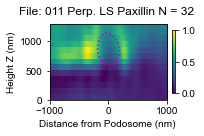

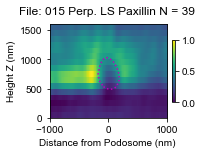

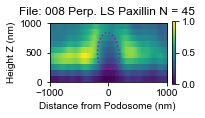

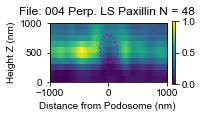

In [16]:
for i in range(4):

    plt.figure(figsize=(3.,4.))
    x = np.linspace(-1000, 1000, len(perp_ls_act_mean[i][0].T))
    y = np.linspace(0, len(perp_ls_act_mean[i])*z_step, len(perp_ls_act_mean[i]))
    X, Y = np.meshgrid(x, y)


    plt.imshow(max_min_scaled(perp_ls_other_mean[i]),extent=[-1000,1000,0,len(perp_ls_act_mean[i])*z_step],aspect=1,origin='lower',interpolation='none',cmap=plt.cm.viridis)

    # plt.imshow(max_min_scaled(np.mean(perp_ls_act_same,axis=1)),extent=[-1000,1000,0,100*len(actin_stack)],aspect=2,origin='lower',interpolation='none',cmap=plt.cm.afmhot)
    plt.colorbar(fraction=0.025, pad=0.04)
    
    CS = plt.contour(X,Y,max_min_scaled(perp_ls_act_mean[i]),levels=np.array([0.7]), colors='m', linestyles=':')

    plt.title('File: %s Perp. LS Paxillin N = %i ' %(file_inds[i],np.shape(all_perp_ls_act[i])[1]),y=1.04)
    plt.ylabel('Height Z (nm)')
    plt.xlabel('Distance from Podosome (nm) ')
    plt.tight_layout()
#     plt.savefig('../../../SH-CH/WorkingFiguresCurrent/Figure6_AdhesionAndCap/IndividualPlots/Disc_3DSIM_pax_PerpLS_File%s.pdf' %file_inds[i],transparent=True,dpi=300,bbox_inches='tight')


### Get mirrored radial averaging heatmaps for 3D SIM on Uniform IgG

In [18]:
image_loc = '../../../SH-CH/3D-SIM paxillin/UniformIgG/'
file_name = image_loc
path, dirs, files = os.walk(file_name).__next__()
len_files = len(files)-1

files = [file for file in files if 'tif' in file]
actin_files = [file for file in files if 'C=1' in file]
other_files = [file for file in files if 'C=0' in file]
file_inds = [file.split(' ')[1].split('_')[0] for file in actin_files]

['009', '001', '003']


In [19]:
pix_sizes = dict.fromkeys(['009','001'] ,30.72/1024)

pix_sizes['003'] = 17.01/567

z_step = 100 #nm

In [ ]:
other_species = 'Paxillin'
pod_analysis_distance = 2. #um

all_clusters = []
all_centers = []

all_pods = []
all_sites = []
for ind in file_inds: #['008'],'003']:
    try:
        actin_file = image_loc + [file for file in actin_files if ind in file][0]
        print(actin_file)
    #     other_file = image_loc + [file for file in other_files if ind in file][0]
    #     save_file = save_file_name+ind+'.tif'

        actin_stack = io.imread(actin_file)
    #     other_stack = io.imread(other_file)

        actin = np.mean(actin_stack,axis=0)
        plt.figure()
        plt.imshow(actin)
    #     other = np.mean(other_stack,axis=0)

        pix_size = pix_sizes[ind]
        len_micron = int(1/pix_size)
        pod_filt = int(0.5*len_micron)
        site_filt = int(1.5*len_micron)

        file_name = ''
        pods, sites = find_pod_and_sites_tda(actin,pod_filt,site_filt,plot_bool=False,plot_pers=False,save_file = file_name)
        all_pods.append([pods])
        all_sites.append([sites])

        print(ind + ' is done')
    except:
        print(ind + ' has failed')
        continue



In [20]:
# pickle.dump({'all_pods':all_pods,'all_sites':all_sites},open('uniform_3DSIM_pax_FoundLoc.pickled','wb'))

stored_results = pickle.load(open('uniform_3DSIM_pax_FoundLoc.pickled','rb'))
all_pods = stored_results["all_pods"]
all_sites = stored_results["all_sites"]

In [21]:
all_rad_act = []
all_rad_other = []
# plt.figure()
for j,ind in enumerate(file_inds):
    
    actin_file = image_loc + [file for file in actin_files if ind in file][0]
    other_file = image_loc + [file for file in other_files if ind in file][0]
#     save_file = save_file_name+ind+'.tif'

    actin_stack = io.imread(actin_file)
    other_stack = io.imread(other_file)
    
    pix_size = pix_sizes[ind]

    rad_act=[]
    rad_other = []
    for i,image in enumerate(actin_stack):

        actin=image
        other = other_stack[i]

        #clusters = all_clusters[j]
#         clusters = np.vstack(clusters)
        podosome_centers = np.array(all_pods[j]) #np.vstack(clusters) #np.array([list(point) for cluster in clusters for point in cluster])
        cxs = podosome_centers.T[0]
        cys = podosome_centers.T[1]

        rad_profs_act, x_ums = radial_averaging_from_pods(cxs,cys,actin,pix_size,1.)
        rad_profs_other, x_ums = radial_averaging_from_pods(cxs,cys,other,pix_size,1.)

        rad_act.append(rad_profs_act)
        rad_other.append(rad_profs_other)
    all_rad_act.append(rad_act)
    all_rad_other.append(rad_other)

In [26]:
def out_in_stack(in_dist, out_dist):
    return([np.hstack([in_dist[i][:1:-1],out_dist[i]]) for i in range(len(in_dist))])

In [29]:
rad_act_mean = []
rad_other_mean = []
for i in range(3):
    rad_act_mean.append(np.mean(all_rad_act[i],axis=1))
    rad_other_mean.append(np.mean(all_rad_other[i],axis=1))

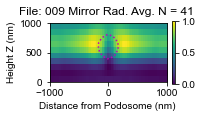

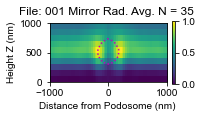

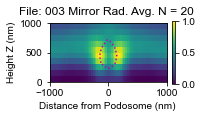

In [30]:
for i in range(3):

    plt.figure(figsize=(3.,4.))
    
    average_radial = rad_act_mean[i]
    average_radial_mirrored = out_in_stack(average_radial,average_radial) #np.hstack([average_radial.T[:-1][::-1].T,average_radial])

    average_radial_other = rad_other_mean[i]
    average_radial_other_mirrored = out_in_stack(average_radial_other,average_radial_other) #np.hstack([average_radial.T[:-1][::-1].T,average_radial])

    x = np.linspace(-1000, 1000, len(average_radial_mirrored[0].T))
    y = np.linspace(0, len(average_radial_mirrored)*z_step, len(average_radial_mirrored))
    X, Y = np.meshgrid(x, y)


    plt.imshow(max_min_scaled(average_radial_other_mirrored),extent=[-1000,1000,0,len(average_radial)*z_step],aspect=1,origin='lower',interpolation='none',cmap=plt.cm.viridis)

    # plt.imshow(max_min_scaled(np.mean(perp_ls_act_same,axis=1)),extent=[-1000,1000,0,100*len(actin_stack)],aspect=2,origin='lower',interpolation='none',cmap=plt.cm.afmhot)
    plt.colorbar(fraction=0.025, pad=0.04)
    
    CS = plt.contour(X,Y,max_min_scaled(average_radial_mirrored),levels=np.array([0.7]), colors='m', linestyles=':')

    plt.title('File: %s Mirror Rad. Avg. N = %i ' %(file_inds[i],np.shape(all_rad_act[i])[1]),y=1.04)
    plt.ylabel('Height Z (nm)')
    plt.xlabel('Distance from Podosome (nm) ')
    plt.tight_layout()
#     plt.savefig('../../../SH-CH/WorkingFiguresCurrent/Figure6_AdhesionAndCap/IndividualPlots/Uniform_3DSIM_paxillin_MirrorRadAvg_File%s.pdf' %file_inds[i],transparent=True,dpi=300,bbox_inches='tight')
